In [ ]:
import torch
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [ ]:
train_data = train_df.drop('ID', axis = 1)

In [ ]:
columns_change = ['Signup_Length', 'Voice_mail_usage',\
                  'Noon_len','Noon_calling_cnt','Noon_fee',\
                  'Late_len', 'Late_calling_cnt','Late_fee',\
                  'Night_len','Night_calling_cnt','Night_fee',\
                  'Counseling_cnt','Cancel_status']
train_data.columns = columns_change

In [ ]:
# 시간대 별 묶음음
# 요금 = 분당 요금금
train_data['total_call_time'] = train_data['Noon_len'] + train_data['Late_len'] + train_data['Night_len']
train_data['total_call_cnt'] = train_data['Noon_calling_cnt'] + train_data['Late_calling_cnt'] + train_data['Night_calling_cnt']

# total fee를 계산
train_data['total_call_fee'] = train_data['Noon_fee'] + train_data['Late_fee']+train_data['Night_fee']
train_data['noon_rate'] = train_data['Noon_fee'] / train_data['Noon_len']
train_data['late_rate'] = train_data['Late_fee'] / train_data['Late_len']
train_data['night_rate'] = train_data['Night_fee'] / train_data['Night_len']

train_data['noon_per_night_len'] = (train_data['Noon_len'] + train_data['Late_len'] )/ train_data['Late_len']
train_data['noon_per_night_fee'] = (train_data['Noon_fee'] + train_data['Late_fee'] )/ train_data['Late_fee']

train_data['voice_mail_since_sign'] = train_data['Voice_mail_usage'] / train_data['Signup_Length']
train_data['consult_since_sign'] = train_data['Counseling_cnt'] / train_data['Signup_Length']

train_data['voice_mail_fee'] = train_data['Voice_mail_usage'] / train_data['total_call_fee']
train_data['consult_fee'] = train_data['Counseling_cnt'] / train_data['total_call_fee']

#
train_data.loc[train_data['Signup_Length'] > 475, 'Signup_Length'] = 475
train_data.loc[train_data['Voice_mail_usage'] > 55, 'Voice_mail_usage'] = 55
train_data = train_data.replace(np.inf,0)

In [ ]:
train_data.describe()

,Signup_Length,Voice_mail_usage,Noon_len,Noon_calling_cnt,Noon_fee,Late_len,Late_calling_cnt,Late_fee,Night_len,Night_calling_cnt,...,total_call_fee,noon_rate,late_rate,night_rate,noon_per_night_len,noon_per_night_fee,voice_mail_since_sign,consult_since_sign,voice_mail_fee,consult_fee
count,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,...,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000
mean,158.427020,10.178709,250.563457,159.175728,41.091447,263.247215,158.474536,25.394260,263.438285,157.047417,...,78.560356,0.183930,0.097251,0.047064,2.223592,2.885015,0.174770,0.033108,0.163311,0.031475
std,112.549887,17.025935,84.403350,101.573057,23.179017,74.064922,102.200293,8.146126,73.778416,101.721601,...,28.954492,0.188713,0.021319,0.034361,15.145780,2.053079,0.896157,0.095500,0.382575,0.029062
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,20.800000,20.000000,...,17.040000,0.000000,0.000000,0.006792,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.000000,0.000000,222.800000,88.000000,24.400000,223.700000,87.000000,22.220000,223.700000,87.000000,...,57.400000,0.103081,0.086233,0.018052,1.871774,2.026899,0.000000,0.006920,0.000000,0.015631
50%,118.000000,1.000000,234.000000,117.500000,30.800000,243.000000,112.000000,23.320000,242.800000,108.000000,...,68.890000,0.132833,0.097686,0.041727,1.996052,2.237779,0.004545,0.009852,0.013393,0.028978
75%,228.000000,22.000000,289.600000,223.000000,45.900000,290.300000,223.000000,28.820000,290.500000,222.000000,...,95.830000,0.207783,0.107290,0.079529,2.089017,3.057249,0.099099,0.035242,0.256044,0.038797
max,475.000000,55.000000,481.900000,489.000000,118.600000,481.600000,489.000000,49.980000,481.800000,490.000000,...,184.240000,20.000000,0.391630,0.398077,2101.000000,38.433628,40.500000,5.000000,25.849232,0.336289


<Axes: >

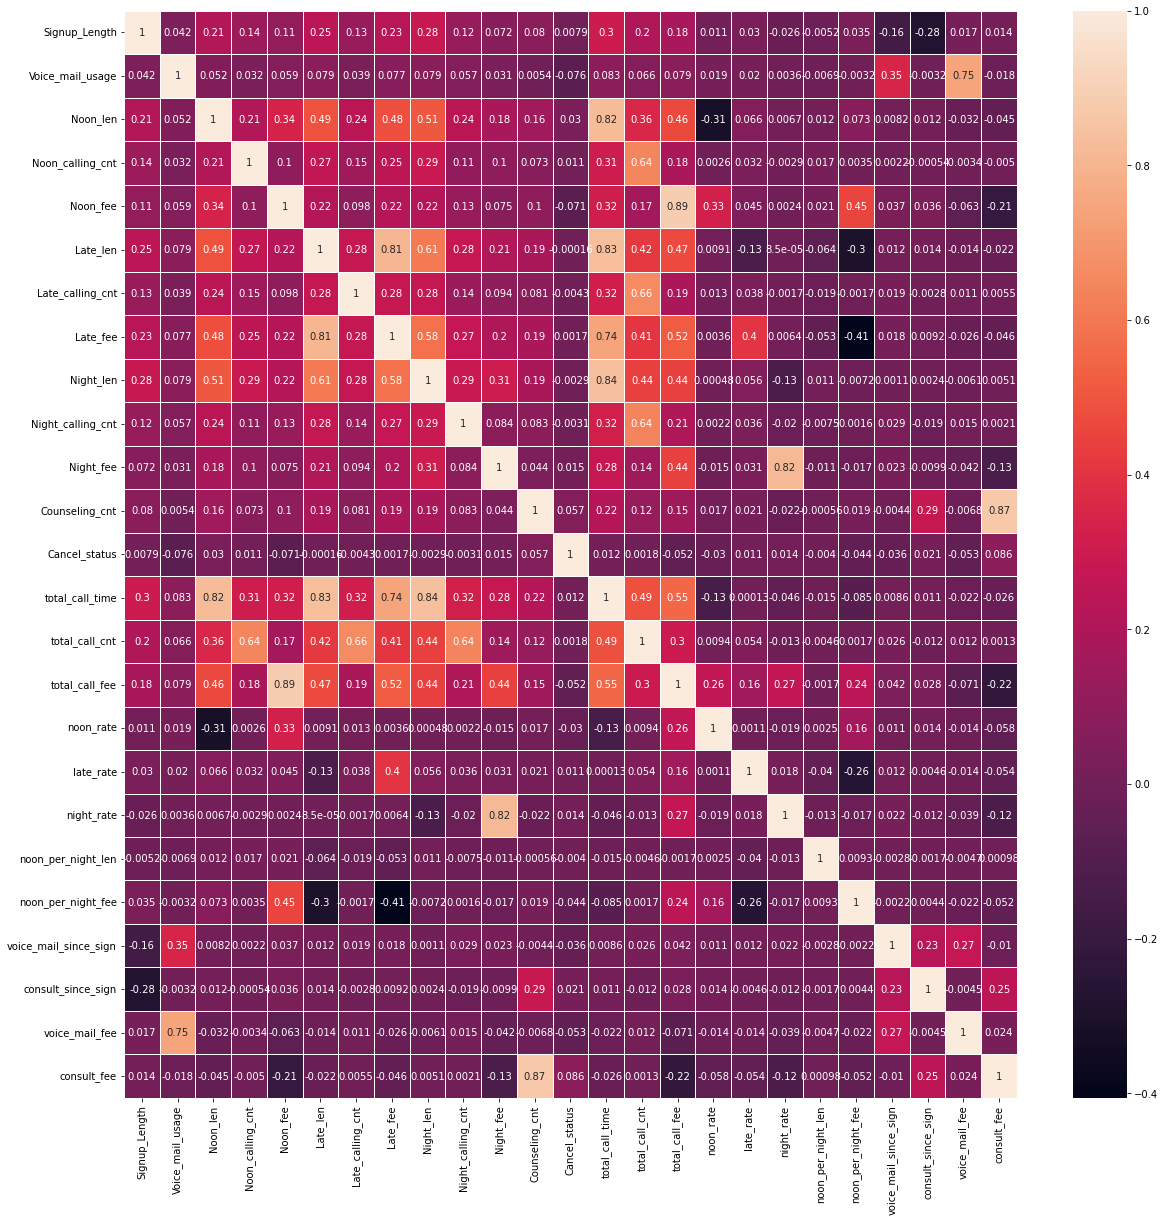

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
train_corr = train_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(train_corr, annot=True, linewidth=1)

In [ ]:
model = xgb.XGBClassifier()
train_x= train_data.drop('Cancel_status', axis = 1)
train_y= train_data['Cancel_status']

params = {
    'n_estimators ': [50,100,300],
    'min_samples_split': [2, 3],
    'min_child_weight' : [1,0.1,0],
    'colsample_bytree' : [0.7,0.9],
    'colsample_bylevel':[0.7,0.9],
    'max_depth' :[None, 5, 10],
    'gamma' : [0,5,10],
    'objective' : ['binary:logistic']
}
grid_tree = GridSearchCV(model, param_grid=params, cv=3, refit=True, verbose = 1)
grid_tree.fit(train_x, train_y)
print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)
em = grid_tree.best_estimator_


Fitting 3 folds for each of 648 candidates, totalling 1944 fits


ValueError: ignored

In [ ]:
test_data = test_df.drop('ID', axis = 1)
columns_change = ['Signup_Length', 'Voice_mail_usage',\
                  'Noon_len','Noon_calling_cnt','Noon_fee',\
                  'Late_len', 'Late_calling_cnt','Late_fee',\
                  'Night_len','Night_calling_cnt','Night_fee',\
                  'Counseling_cnt']
test_data.columns = columns_change
# 시간대 별 묶음음
test_data['total_call_time'] = test_data['Noon_len'] + test_data['Late_len'] + test_data['Night_len']
test_data['total_call_cnt'] = test_data['Noon_calling_cnt'] + test_data['Late_calling_cnt'] + test_data['Night_calling_cnt']
# total fee를 계산

test_data['total_call_fee'] = test_data['Noon_fee'] + test_data['Late_fee']+test_data['Night_fee']
test_data['noon_rate'] = test_data['Noon_fee'] / test_data['Noon_len']
test_data['late_rate'] = test_data['Late_fee'] / test_data['Late_len']
test_data['night_rate'] = test_data['Night_fee'] / test_data['Night_len']

test_data['noon_per_night_len'] = (test_data['Noon_len'] + test_data['Late_len'] )/ test_data['Late_len']
test_data['noon_per_night_fee'] = (test_data['Noon_fee'] + test_data['Late_fee'] )/ test_data['Late_fee']

test_data['voice_mail_since_sign'] = test_data['Voice_mail_usage'] / test_data['Signup_Length']
test_data['consult_since_sign'] = test_data['Counseling_cnt'] / test_data['Signup_Length']

test_data['voice_mail_fee'] = test_data['Voice_mail_usage'] / test_data['total_call_fee']
test_data['consult_fee'] = test_data['Counseling_cnt'] / test_data['total_call_fee']

#
test_data.loc[test_data['Signup_Length'] > 475, 'Signup_Length'] = 475
test_data.loc[test_data['Voice_mail_usage'] > 55, 'Voice_mail_usage'] = 55
test_data = test_data.replace(np.inf,0)

In [ ]:
prediction = em.predict(test_data)

In [ ]:
print(prediction)

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission.describe()

In [ ]:
cnt = 0;
for i in prediction:
  if i == 1:
    cnt +=1
print(cnt)

In [ ]:
submission['전화해지여부'] = prediction
submission.to_csv('./submit.csv', index = False)